Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

![Impressions](https://PixelServer20190423114238.azurewebsites.net/api/impressions/MachineLearningNotebooks/how-to-use-azureml/automated-machine-learning/classification-with-deployment/auto-ml-classification-with-deployment.png)

# Automated Machine Learning
_**Classification with Deployment**_

## Contents
1. [Introduction](#Introduction)
1. [Setup](#Setup)
1. [Train](#Train)
1. [Deploy](#Deploy)
1. [Test](#Test)

## Introduction

In this example we use the scikit learn's [digit dataset](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) to showcase how you can use AutoML for a simple classification problem and deploy it to an Azure Container Instance (ACI).

Make sure you have executed the [configuration](../../../configuration.ipynb) before running this notebook.

In this notebook you will learn how to:
1. Create an experiment using an existing workspace.
2. Configure AutoML using `AutoMLConfig`.
3. Train the model using local compute.
4. Explore the results.
5. Register the model.
6. Create a container image.
7. Create an Azure Container Instance (ACI) service.
8. Test the ACI service.

## Setup

As part of the setup you have already created an Azure ML `Workspace` object. For AutoML you will need to create an `Experiment` object, which is a named object in a `Workspace` used to run experiments.

In [1]:
import json
import logging

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets

import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.train.automl import AutoMLConfig
from azureml.train.automl.run import AutoMLRun

WARNING - From /home/jeffrey/anaconda3/envs/RL/lib/python3.7/site-packages/azureml/automl/core/_vendor/automl/client/core/runtime/tf_wrappers.py:36: The name tf.logging.set_verbosity is deprecated. Please use tf.compat.v1.logging.set_verbosity instead.

WARNING - From /home/jeffrey/anaconda3/envs/RL/lib/python3.7/site-packages/azureml/automl/core/_vendor/automl/client/core/runtime/tf_wrappers.py:36: The name tf.logging.ERROR is deprecated. Please use tf.compat.v1.logging.ERROR instead.



In [2]:
ws = Workspace.from_config()

# choose a name for experiment
experiment_name = 'automl-classification-deployment'

experiment=Experiment(ws, experiment_name)

output = {}
output['SDK version'] = azureml.core.VERSION
output['Subscription ID'] = ws.subscription_id
output['Workspace'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Experiment Name'] = experiment.name
pd.set_option('display.max_colwidth', -1)
outputDf = pd.DataFrame(data = output, index = [''])
outputDf.T

,
SDK version,1.0.69
Subscription ID,8170d900-06ad-4a1d-babd-1a30120ea257
Workspace,Pipeline
Resource Group,WS10300812-rg1
Location,northcentralus
Experiment Name,automl-classification-deployment


## Train

Instantiate a AutoMLConfig object. This defines the settings and data used to run the experiment.

|Property|Description|
|-|-|
|**task**|classification or regression|
|**primary_metric**|This is the metric that you want to optimize. Classification supports the following primary metrics: <br><i>accuracy</i><br><i>AUC_weighted</i><br><i>average_precision_score_weighted</i><br><i>norm_macro_recall</i><br><i>precision_score_weighted</i>|
|**iteration_timeout_minutes**|Time limit in minutes for each iteration.|
|**iterations**|Number of iterations. In each iteration AutoML trains a specific pipeline with the data.|
|**n_cross_validations**|Number of cross validation splits.|
|**X**|(sparse) array-like, shape = [n_samples, n_features]|
|**y**|(sparse) array-like, shape = [n_samples, ], Multi-class targets.|

In [3]:
digits = datasets.load_digits()
X_train = digits.data[10:,:]
y_train = digits.target[10:]

automl_config = AutoMLConfig(task = 'classification',
                             name = experiment_name,
                             debug_log = 'automl_errors.log',
                             primary_metric = 'AUC_weighted',
                             iteration_timeout_minutes = 20,
                             iterations = 10,
                             verbosity = logging.INFO,
                             X = X_train, 
                             y = y_train)

Call the `submit` method on the experiment object and pass the run configuration. Execution of local runs is synchronous. Depending on the data and the number of iterations this can run for a while.
In this example, we specify `show_output = True` to print currently running iterations to the console.

In [4]:
local_run = experiment.submit(automl_config, show_output = True)

Running on local machine
Parent Run ID: AutoML_382f661c-b924-475f-a8f0-e9aa322bd36e
Current status: DatasetCrossValidationSplit. Generating CV splits.

****************************************************************************************************
DATA GUARDRAILS SUMMARY:
For more details, use API: run.get_guardrails()

TYPE:         Cross Validation
STATUS:       DONE
DESCRIPTION:  Each iteration of the trained model was validated through cross-validation.

TYPE:         Class Balancing Detection
STATUS:       PASSED
DESCRIPTION:  Classes are balanced in the training data.

****************************************************************************************************
Current status: ModelSelection. Beginning model selection.

****************************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summary description of the pipeline being evaluated.
DURATION: Time taken for the current iterati

In [5]:
local_run

Experiment,Id,Type,Status,Details Page,Docs Page
automl-classification-deployment,AutoML_382f661c-b924-475f-a8f0-e9aa322bd36e,automl,Completed,Link to Azure Portal,Link to Documentation


## Datastore

datastore = Datastore.register_azure_file_share(workspace=ws, 
                                                  datastore_name='sklearn', 
                                                  file_share_name='sklearn',
                                                  account_name='sklearn', 
                                                  account_key='FTHEsEu2FqB5h1VSitiGV1qsidNFka86CS+ONMBJmav7sG6fei4yOk6NKsOv1wQ/FKGg37KYzcp0XDHd51QPaw==',
                                                  create_if_not_exists=True)

from azureml.core.workspace import Workspace
from azureml.core.datastore import Datastore
from azureml.core.dataset import Dataset

datastore_name = 'sklearn'

# get existing workspace
workspace = Workspace.from_config()

# retrieve an existing datastore in the workspace by name
datastore = Datastore.get(workspace, datastore_name)

import pandas as pd

df = pd.read_csv('digits.csv', header=None)
df.head()

## 그냥 웹에서 GUI 로 등록하는게 편함

![dataset](img/dataset.png)

## Deploy

### Retrieve the Best Model

Below we select the best pipeline from our iterations. The `get_output` method on `automl_classifier` returns the best run and the fitted model for the last invocation. Overloads on `get_output` allow you to retrieve the best run and fitted model for *any* logged metric or for a particular *iteration*.

In [6]:
best_run, fitted_model = local_run.get_output()

### Register the Fitted Model for Deployment
If neither `metric` nor `iteration` are specified in the `register_model` call, the iteration with the best primary metric is registered.

In [7]:
description = 'AutoML Model'
tags = None
model = local_run.register_model(description = description, tags = tags)

print(local_run.model_id) # This will be written to the script file later in the notebook.

AutoML382f661cbbest


### Create Scoring Script -> Inference 시 필요함

In [8]:
model

Model(workspace=Workspace.create(name='Pipeline', subscription_id='8170d900-06ad-4a1d-babd-1a30120ea257', resource_group='WS10300812-rg1'), name=AutoML382f661cbbest, id=AutoML382f661cbbest:1, version=1, tags={}, properties={})

In [9]:
%%writefile score.py
import pickle
import json
import numpy
import azureml.train.automl
from sklearn.externals import joblib
from azureml.core.model import Model


def init():
    global model
    model_path = Model.get_model_path(model_name = '<<modelid>>') # this name is model.id of model that we want to deploy
    # deserialize the model file back into a sklearn model
    model = joblib.load(model_path)

def run(rawdata):
    try:
        data = json.loads(rawdata)['data']
        data = numpy.array(data)
        result = model.predict(data)
    except Exception as e:
        result = str(e)
        return json.dumps({"error": result})
    return json.dumps({"result":result.tolist()})

Writing score.py


### Create a YAML File for the Environment

To ensure the fit results are consistent with the training results, the SDK dependency versions need to be the same as the environment that trains the model. The following cells create a file, myenv.yml, which specifies the dependencies from the run.

In [10]:
experiment = Experiment(ws, experiment_name)
ml_run = AutoMLRun(experiment = experiment, run_id = local_run.id)

In [11]:
dependencies = ml_run.get_run_sdk_dependencies(iteration = 7)

In [12]:
for p in ['azureml-train-automl', 'azureml-core']:
    print('{}\t{}'.format(p, dependencies[p]))

azureml-train-automl	1.0.69
azureml-core	1.0.69


In [13]:
from azureml.core.conda_dependencies import CondaDependencies

myenv = CondaDependencies.create(conda_packages=['numpy','scikit-learn','py-xgboost<=0.80'],
                                 pip_packages=['azureml-defaults','azureml-train-automl'])

conda_env_file_name = 'myenv.yml'
myenv.save_to_file('.', conda_env_file_name)

'myenv.yml'

In [14]:
# Substitute the actual version number in the environment file.
# This is not strictly needed in this notebook because the model should have been generated using the current SDK version.
# However, we include this in case this code is used on an experiment from a previous SDK version.

with open(conda_env_file_name, 'r') as cefr:
    content = cefr.read()

with open(conda_env_file_name, 'w') as cefw:
    cefw.write(content.replace(azureml.core.VERSION, dependencies['azureml-train-automl']))

# Substitute the actual model id in the script file.

script_file_name = 'score.py'

with open(script_file_name, 'r') as cefr:
    content = cefr.read()

with open(script_file_name, 'w') as cefw:
    cefw.write(content.replace('<<modelid>>', local_run.model_id))

### Deploy the model as a Web Service on Azure Container Instance

Create the configuration needed for deploying the model as a web service service.

In [15]:
from azureml.core.model import InferenceConfig
from azureml.core.webservice import AciWebservice

inference_config = InferenceConfig(runtime = "python", 
                                   entry_script = script_file_name,
                                   conda_file = conda_env_file_name)

aciconfig = AciWebservice.deploy_configuration(cpu_cores = 1, 
                                               memory_gb = 1, 
                                               tags = {'area': "digits", 'type': "automl_classification"}, 
                                               description = 'sample service for Automl Classification')

In [16]:
from azureml.core.webservice import Webservice
from azureml.core.model import f

aci_service_name = 'automl-sample-01'
print(aci_service_name)
aci_service = Model.deploy(ws, aci_service_name, [model], inference_config, aciconfig)
aci_service.wait_for_deployment(True)
print(aci_service.state)

automl-sample-01
Running..................................
SucceededACI service creation operation finished, operation "Succeeded"
Healthy


### Get the logs from service deployment

In [17]:
if aci_service.state != 'Healthy':
    # run this command for debugging.
    print(aci_service.get_logs())

### Delete a Web Service

In [18]:
#aci_service.delete()

## Test

4


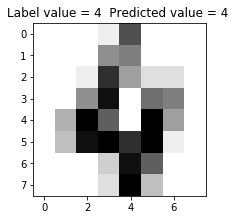

0


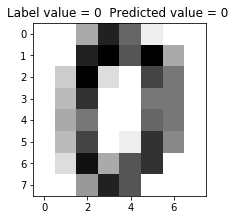

7


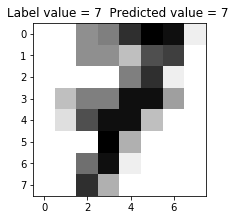

In [19]:
#Randomly select digits and test
digits = datasets.load_digits()
X_test = digits.data[:10, :]
y_test = digits.target[:10]
images = digits.images[:10]

for index in np.random.choice(len(y_test), 3, replace = False):
    print(index)
    test_sample = json.dumps({'data':X_test[index:index + 1].tolist()})
    predicted = aci_service.run(input_data = test_sample)
    label = y_test[index]
    predictedDict = json.loads(predicted)
    title = "Label value = %d  Predicted value = %s " % ( label,predictedDict['result'][0])
    fig = plt.figure(1, figsize = (3,3))
    ax1 = fig.add_axes((0,0,.8,.8))
    ax1.set_title(title)
    plt.imshow(images[index], cmap = plt.cm.gray_r, interpolation = 'nearest')
    plt.show()